# 주제: 인물사진 만들기

## 데이터
사진 3장

## 목표
1. 아웃포커싱 효과가 적용된 인물모드 사진, 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작
2. 인물사진에서 발생한 문제점을 정확히 지적한 사진 제출
3. semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시

# step 1: 인물사진, 동물사진, 크로마키 사진 제작
## 1. 인물사진
### (1) 라이브러리 및 데이터 불러오기

In [99]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(168, 299, 3)


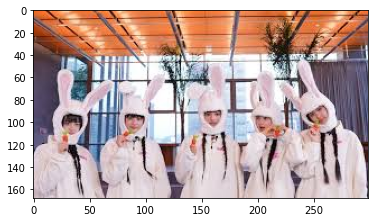

In [100]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/뉴진스토끼.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### (2) 모델 불러오기

In [101]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f2883b92ee0>)

In [102]:
model = semantic_segmentation() #PixelLib 라이브러리 이용하여 인스턴스를 만듦
model.load_pascalvoc_model(model_file) # pascal voc

### (3) image segmentation

In [103]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascal

In [104]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

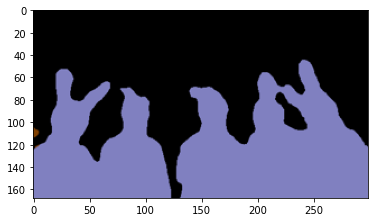

In [105]:
#이미지 분할한 뒤 출력
plt.imshow(output)
plt.show()

In [106]:
segvalues # 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0, 15, 20]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [107]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
tv


### (4) 사람만 추출하기

In [108]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [109]:
colormap[15]

array([192, 128, 128])

In [110]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (128,128,192)

(168, 299)


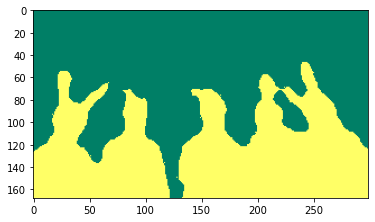

In [111]:
# seg_color 값을 제외하고 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
plt.show()

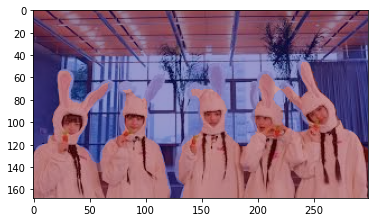

In [112]:
# 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (5) 배경 흐리게 하기

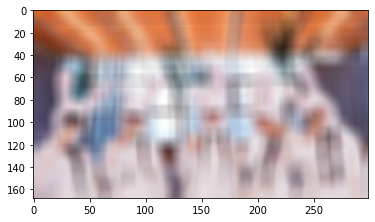

In [113]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

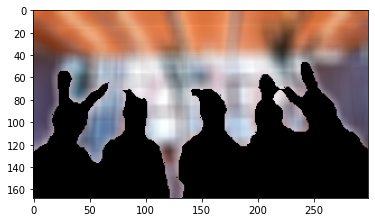

In [114]:
# BGR을 RBG로 바꾸기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### (6) 흐린 배경과 원본 그림 합성

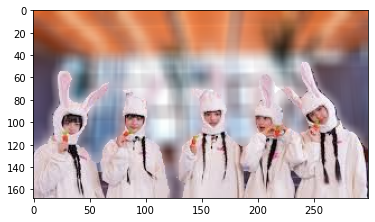

In [115]:
# 흐린 배경과 원본 그림 합성
newjeans = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(newjeans, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 동물사진

(183, 275, 3)
- 원본이미지


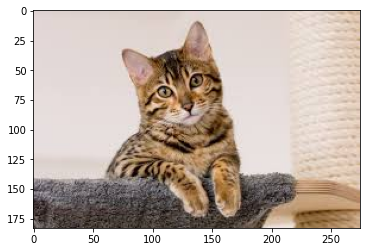

- 분할한 이미지


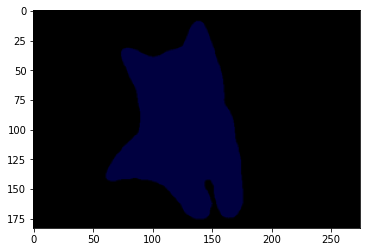

background
cat
[64  0  0]


In [116]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
print("- 원본이미지")
plt.show()

# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file) 

# 이미지 분할
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

# segmentAsPascal
segvalues, output = model.segmentAsPascalvoc(img_path) 

# 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 분할한 이미지 출력
plt.imshow(output)
print("- 분할한 이미지")
plt.show()

# 분할한 이미지 배열값 출력
segvalues 

#라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 8 고양이 12 강아지
print(colormap[8])

(183, 275)
- 분할한 이미지 선명하게 보기


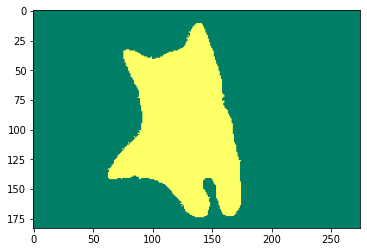

- 원본이미지의 컬러마스크


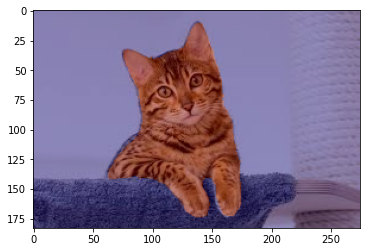

- 블러된 원본 이미지


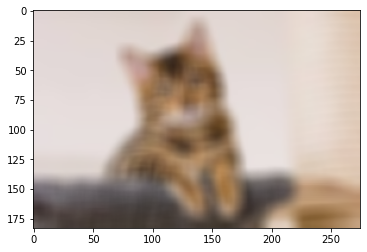

- 블러된 배경만 확인하기


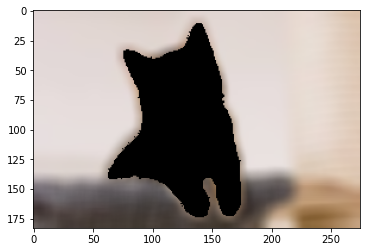

- 완성본


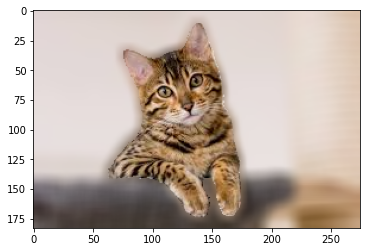

In [117]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (0, 0, 64)

# 추출한 image segment 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
print("- 분할한 이미지 선명하게 보기")
plt.show()

# img_show로 배경 흐리게 만들기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 컬러 마스크를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("- 원본이미지의 컬러마스크")
plt.show()

#블러된 원본 이미지
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 원본 이미지")
plt.show()

# 블러된 배경민 확인
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 배경만 확인하기")
plt.show()

# 합성된 이미지 출력
cat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
print("- 완성본")
plt.show()

## 3. 배경 크로마키 적용하기

(225, 225, 3)
- 원본이미지


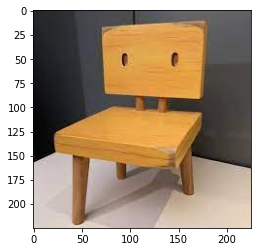

- 분할한 이미지


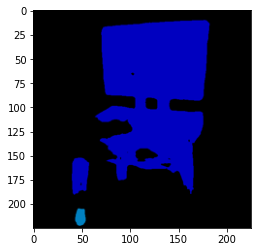

background
chair
diningtable
[192   0   0]


In [118]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/의자.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
print("- 원본이미지")
plt.show()

# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file) 

# 이미지 분할
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

# segmentAsPascal
segvalues, output = model.segmentAsPascalvoc(img_path) 

# 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 분할한 이미지 출력
plt.imshow(output)
print("- 분할한 이미지")
plt.show()

# 분할한 이미지 배열값 출력
segvalues 

#라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 21 토끼
print(colormap[9])

(225, 225)
- 분할한 이미지 선명하게 보기


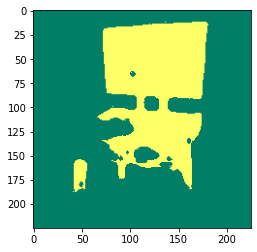

- 원본이미지의 컬러마스크


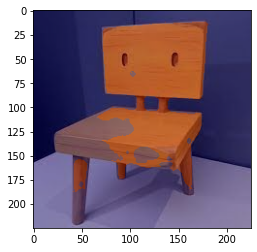

- 블러된 원본 이미지


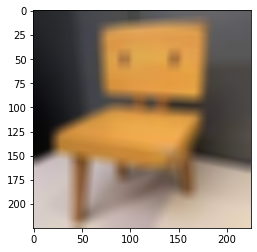

- 블러된 배경만 확인하기


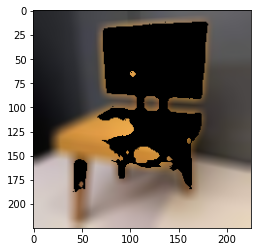

- 완성본


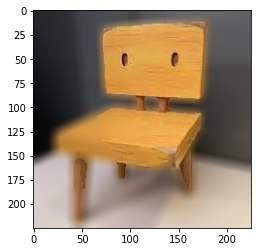

In [119]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (0, 0, 192)

# 추출한 image segment 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
print("- 분할한 이미지 선명하게 보기")
plt.show()

# img_show로 배경 흐리게 만들기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 컬러 마스크를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("- 원본이미지의 컬러마스크")
plt.show()

#블러된 원본 이미지
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 원본 이미지")
plt.show()

# 블러된 배경민 확인
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 배경만 확인하기")
plt.show()

# 합성된 이미지 출력
chair = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(chair, cv2.COLOR_BGR2RGB))
print("- 완성본")
plt.show()

-> <스즈메 문단속>에 남주인공 소타를 우주에도 보내보고 백두산 폭발을 막기위해 백두산 정상에도 올려볼 것이다.

In [120]:
def replace_background(img_path, seg_color, background_path):
    # 이미지 로드
    img_orig = cv2.imread(img_path)
    img_bg = cv2.imread(background_path)

    # 세그멘테이션 모델 로드
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    # 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)

    # 세그멘테이션 결과에 해당하는 부분 추출
    seg_map = np.all(output == seg_color, axis=-1)

    # 배경과 사람 영역 분리
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_fg = cv2.bitwise_and(img_orig, img_mask_color)

    # 배경 이미지 크기 조정
    img_bg_resized = cv2.resize(img_bg, (img_orig.shape[1], img_orig.shape[0]))

    # 크로마키 사진과 사람 영역 합성
    img_concat = np.where(img_mask_color == 255, img_fg, img_bg_resized)
    
    # 원본 이미지와 최종 이미지 함께 출력
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Final Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

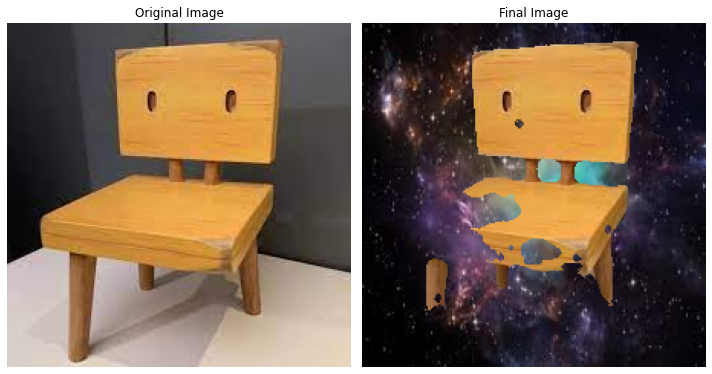

In [121]:
origin = os.getenv('HOME')+'/aiffel/human_segmentation/images/의자.jpg' 
background = os.getenv('HOME')+'/aiffel/human_segmentation/images/우주1.jpg'
replace_background(origin, (0, 0, 192), background)

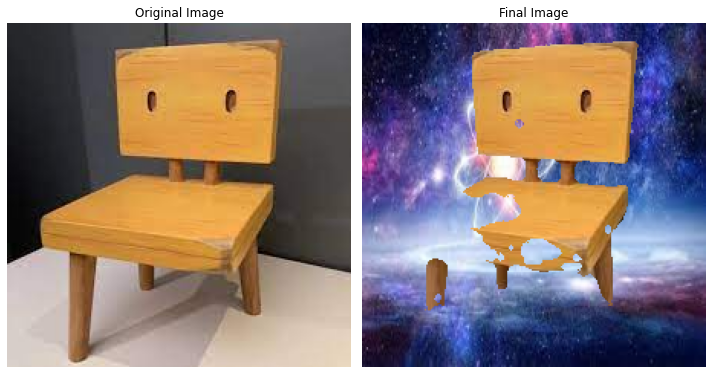

In [122]:
origin = os.getenv('HOME')+'/aiffel/human_segmentation/images/의자.jpg' 
background = os.getenv('HOME')+'/aiffel/human_segmentation/images/우주2.jpg'
replace_background(origin, (0, 0, 192), background)

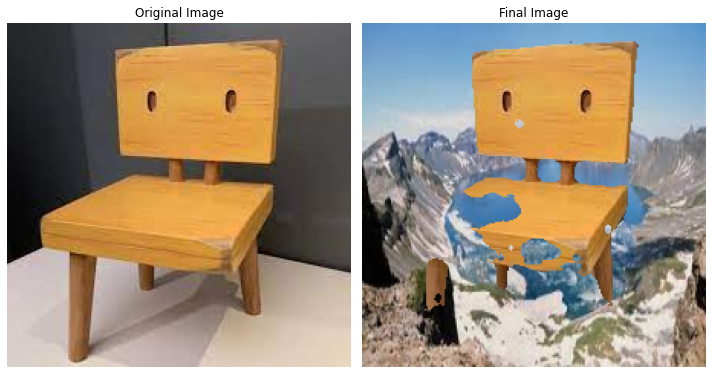

In [123]:
origin = os.getenv('HOME')+'/aiffel/human_segmentation/images/의자.jpg' 
background = os.getenv('HOME')+'/aiffel/human_segmentation/images/백두산.jpg'
replace_background(origin, (0, 0, 192), background)

-> image segmentation이 제대로 되진 않았지만 오히려 이렇게 배경에 스며든 것이 애절하고 만화같다.

# step2: 문제점 발견

## 1. 잘 인식이 되지 않음

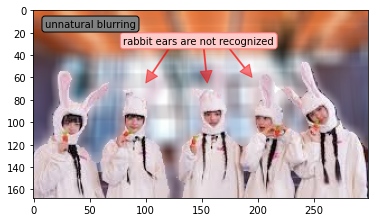

In [124]:
box1 = {'boxstyle': 'round',
        'ec': (1.0, 0.5, 0.5),
        'fc': (1.0, 0.8, 0.8)}
box2 = {'boxstyle': 'round',      
        'fc': (0.5, 0.5, 0.5)}
plt.annotate('.',
ha = 'center', va = 'bottom',
xytext = (125,30),
xy = (100, 65),
arrowprops = { 'facecolor' : 'r', 
              'edgecolor':'r', 
              'width' : 1,
              'shrink' : 0.002, 
              'alpha':0.5
              })
plt.annotate('.',
ha = 'center', va = 'bottom',
xytext = (150,30),
xy = (155, 65),
arrowprops = { 'facecolor' : 'r', 
              'edgecolor':'r', 
              'width' : 1,
              'shrink' : 0.002, 
              'alpha':0.5
              })
plt.annotate('.',
ha = 'center', va = 'bottom',
xytext = (170,30),
xy = (195, 60),
arrowprops = { 'facecolor' : 'r', 
              'edgecolor':'r', 
              'width' : 1,
              'shrink' : 0.002, 
              'alpha':0.5
              })
plt.imshow(cv2.cvtColor(newjeans, cv2.COLOR_BGR2RGB))
plt.text(80, 30, 'rabbit ears are not recognized', bbox = box1)
plt.text(10, 15, 'unnatural blurring', bbox = box2)
plt.show()

1. 토끼 귀 5개 정도가 인식에 실패하였다.
2. 사람 사이사이 뒷배경은 blur처리가 되지 않았다.
3. blur의 정도가 너무 심해서 배경을 숨기려는 모자이크처럼 보인다

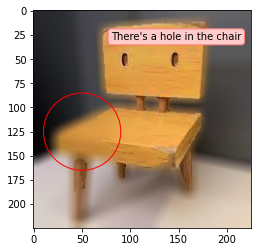

In [125]:
import matplotlib.patches as patches
plt.imshow(cv2.cvtColor(chair, cv2.COLOR_BGR2RGB))
plt.text(80, 30, 'There\'s a hole in the chair', bbox = box1)
circle=patches.Ellipse((50,125), width = 80, height = 80, color='r', fill = False)
plt.gca().add_patch(circle)
plt.show()

## -> 해결 방법?

1. 더 다양한 데이터셋 사용: 더 많은 사진 데이터들을 학습시켜서 정확도를 높히는 방법이 있다. ChatGPT에게 물어보니 코드도 알려준다.

2. 훈련 파라미터 조정: 학습률, 배치 크기, 훈련 에폭 등을 조정할 수 있다.

3. 데이터 전처리 개선: 이미지 크기, 해상도, 정규화 방법 사용할 수 있다.

4. 다른 모델 시도: DeepLab 이외의 U-Net, FCN, PSPNet 등 다른 아키텍처 사용할 수 있다.

5. 후처리 기법 사용: 계 부드러운화(smoothing) 기법을 적용하거나, 작은 객체를 제거하기 위해 객체 크기 기반 필터링을 수행할 수 있다. (CRF사용 등등)

6. 모델 앙상블: 여러 다른 모델을 조합하여 세그멘테이션 결과를 개선할 수 있다. 여러 모델의 예측을 평균 또는 투표 방식으로 결합하여 더 정확한 세그멘테이션 결과를 얻을 수 있다.

## 2. 라벨에 토끼를 추가하였을 때 segmentation엔 분명 되긴하는데 막상 적용하려고 하면 안됨

(177, 285, 3)
- 원본이미지


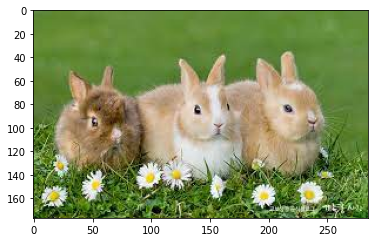

- 분할한 이미지


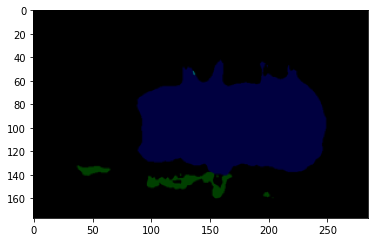

background
bird
cat
pottedplant
[128  64 128]


In [136]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/토끼.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
print("- 원본이미지")
plt.show()

# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드
urllib.request.urlretrieve(model_url, model_file) 

# 이미지 분할
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

# segmentAsPascal
segvalues, output = model.segmentAsPascalvoc(img_path) 

# 라벨 이름
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv', 'rabbit'
]

# 분할한 이미지 출력
plt.imshow(output)
print("- 분할한 이미지")
plt.show()

# 분할한 이미지 배열값 출력
segvalues 

#라벨 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 21 토끼
print(colormap[21])

(177, 285)
- 분할한 이미지 선명하게 보기


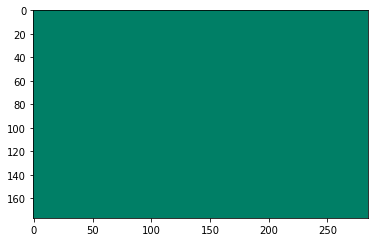

- 원본이미지의 컬러마스크


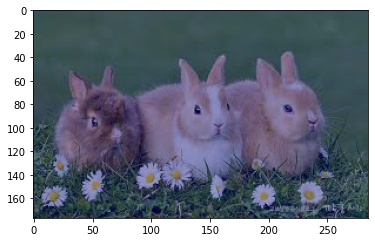

- 블러된 원본 이미지


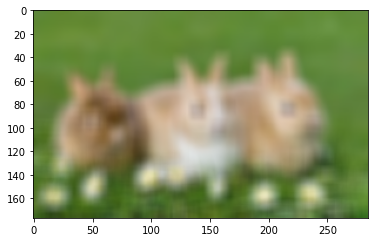

- 블러된 배경만 확인하기


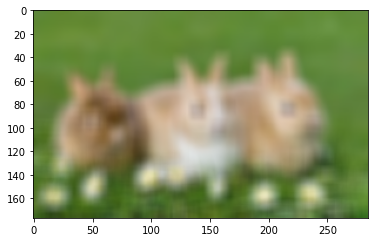

- 완성본


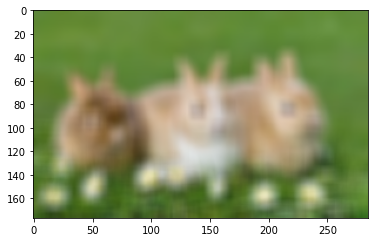

In [137]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (128, 64, 128)

# 추출한 image segment 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
print("- 분할한 이미지 선명하게 보기")
plt.show()

# img_show로 배경 흐리게 만들기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 컬러 마스크를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("- 원본이미지의 컬러마스크")
plt.show()

#블러된 원본 이미지
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 원본 이미지")
plt.show()

# 블러된 배경민 확인
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 배경만 확인하기")
plt.show()

# 합성된 이미지 출력
cat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
print("- 완성본")
plt.show()

-> 아무래도 bird 혹은 cat으로 인식했던 것 같다. 이 파라미터 값을 넣어서 다시 실행시켜봐야겠다.

In [138]:
print(colormap[8]) # cat 

[64  0  0]


(177, 285)
- 분할한 이미지 선명하게 보기


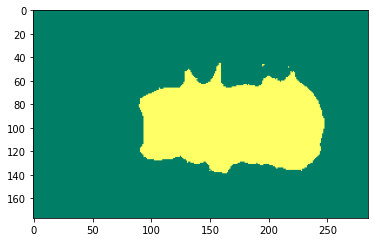

- 원본이미지의 컬러마스크


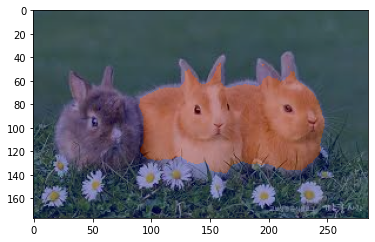

- 블러된 원본 이미지


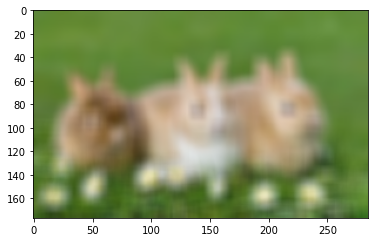

- 블러된 배경만 확인하기


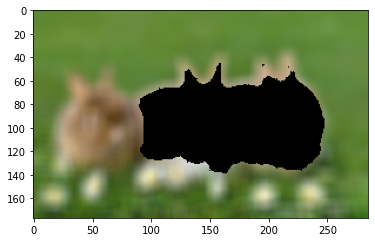

- 완성본


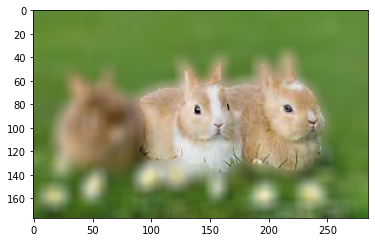

In [139]:
# 색깔 BGR에서 RGB로 바꿈
seg_color = (0, 0, 64)

# 추출한 image segment 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='summer')
print("- 분할한 이미지 선명하게 보기")
plt.show()

# img_show로 배경 흐리게 만들기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 컬러 마스크를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("- 원본이미지의 컬러마스크")
plt.show()

#블러된 원본 이미지
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 원본 이미지")
plt.show()

# 블러된 배경민 확인
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
print("- 블러된 배경만 확인하기")
plt.show()

# 합성된 이미지 출력
cat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
print("- 완성본")
plt.show()

-> 다른 토끼 사진으로도 시도해봐도 이 사진만 되는 것을 보아 그나마 고양이의 특징과 비슷한 면이 있어서 인식이 되는 것 같다. 비록 제대로 되지 않았지만 두마리의 토끼의 얼굴이 보여서 반갑다. rabbit 카테고리도 성공할 수 있도록 다양한 토끼 사진으로 학습시켜서 image segmentation이 되도록 시도해보고 싶다.

# 프로젝트 회고

## 배운점
1. image segmentation이 어떤 과정으로 이루어지는지 배웠다. DeepLab모델의 한계와 발전과정도 조사하면서 알 수 있었다. 이 모델 말고도 U-Net, FCN, PSPNet, mask R-CNN 등이 있는데 시간이 된다면 다른 모델을 적용하여 더 정확히 image segmentation하는 작업을 해보고 싶다.
2. 이미지에 텍스트나 화살표, 도형을 넣는 작업을 하는 방법을 익힐 수 있었다. 그림을 여러가지로 꾸민 코드를 보면 코드가 길어지는 것을 보고 어려울 것이라고 생각했는데 막상 해보니 생각보다 간단했다. 내 맘대로 색도 바꾸고 스타일도 바꾸면서 진행하니 더 재밌었다.  
3. 앞으로 프로젝트를 진행할 때 문제점을 발견하고 이에 대한 솔루션을 생각해보거나 해결을 하는 프로세스를 넣어서 해봐야겠다는 생각이 들었다. 모든 발전은 문제점 제기부터 시작되는 것 같다. 

## 아쉬운점
1. 발견한 문제점을 솔루션대로 다 진행하여 결과를 확인해보고 싶었는데 다음에 한 번 도전해봐야겠다.
2. 토끼사진으로 우주도 보내고 바다도 보내고 들판에도 보내고 이런저런 작업을 해보고 싶었는데 토끼 라벨이 없어서 아쉬웠다. 

## 종합의견
인물사진 모드를 지원하는 카메라 기술도 대단하고 image segmentation을 통해 인물사진모드처럼 만드려는 시도도 흥미로운 것 같다. 앞으로 실생활에서 이루어지는 일들을 컴퓨터로 어떻게 구현하면 좋을지 생각해보며 시도해보는 것도 좋은 경험이 될 것 같다.

# Refernce

1. 사진에 텍스트 삽입하기  
https://codetorial.net/matplotlib/add_text.html  
2. 사진에 화살표 삽입하기  
https://wikidocs.net/141950  
3. 사진에 도형 삽입하기  
https://zzinnam.tistory.com/entry/%EB%A7%89%EB%8C%80%EA%B7%B8%EB%9E%98%ED%94%84%EC%97%90-%EB%8F%84%ED%98%95%ED%83%80%EC%9B%90-%EC%82%BD%EC%9E%85%ED%95%98  
4. DeepLabV3+ 설명  
https://wikidocs.net/143446  
5. CRF 설명  
https://m.blog.naver.com/laonple/221017461464  
6. 아웃포커싱 하는 방법  
https://m.blog.naver.com/typs6301/222172333739  